In [1]:
# conda install joblib --quiet

In [1]:
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from matplotlib.ticker import FuncFormatter
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from collections import Counter


In [60]:
notebook_start_time = time.time()

## 0. Notebook settings

In [15]:
# Set notebook parameters
file_path = "BBDD_V7_SINCO_SoftImputer.csv"
KPI = 'BMA_corregido' # KPI to be considered to classify customers as 0 (to be selected) or 1 (to be excluded)
test_size = 0.30 # Test size for the train-test split
threshold = 0 # if KPI > threshold then customer belongs to class 0; otherwise, customer belongs to class 1
consider_feat_importance = True
per_features_to_select = 0.05 # If consider_feat_importance, percentage of features to select
# Print notebook parameters
print('Working file has been set to', file_path)
print('KPI has been set to', KPI)
print('Paramter test_size has been set to', test_size)
print('Parameter threshold has been set to:', threshold)
print('Parameter consider_feat_importance has been set to:', consider_feat_importance)
if consider_feat_importance:
    print('Paramter per_features_to_select has been set to:', per_features_to_select)

Working file has been set to BBDD_V7_SINCO_SoftImputer.csv
KPI has been set to BMA_corregido
Paramter test_size has been set to 0.3
Parameter threshold has been set to: 0
Parameter consider_feat_importance has been set to: True
Paramter per_features_to_select has been set to: 0.05


## 1. Data preprocessing

In [19]:
# Read the data file
df = pd.read_csv(file_path)
# Remove additional columns since they will not be available for new customers
col_to_remove = ['PrimaTotalPoliza', 'ComisionTotalPoliza', 'SiniestralidadTotalPoliza', 'ExposicionTotalPoliza']
df_original=df.copy()
df = df.drop(columns=col_to_remove)
print("The following columns have been removed:\n", col_to_remove)
print("\nDataset shape (rows, columns):", df.shape)
# Use unicode characters for column names and remove non-alphanumeric characters
df.columns = [unidecode(column) for column in df.columns]
df.columns = [re.sub(r'\W+', '_', column) for column in df.columns]
print("Non-unicode characters in columns' names have been removed to avoid issues with models.")

The following columns have been removed:
 ['PrimaTotalPoliza', 'ComisionTotalPoliza', 'SiniestralidadTotalPoliza', 'ExposicionTotalPoliza']

Dataset shape (rows, columns): (116934, 196)
Non-unicode characters in columns' names have been removed to avoid issues with models.


In [20]:
# Define function to shorten column name
def shorten_column_name(column_name, max_length=30, prefix_length=15, suffix_length=15):
    if len(column_name) <= max_length: return column_name
    else: return column_name[:prefix_length] + '_' + column_name[-suffix_length:]
    
# Shorten column names in DataFrame
df.columns = [shorten_column_name(column) for column in df.columns]
print("Long names in columns have been shortened to avoid issues with models.")

Long names in columns have been shortened to avoid issues with models.


In [21]:
# Display the first rows of the dataframe
df.head()

,id17,id18,id21,id55,id58_1,id58_2,id58_3,id59,id60,id61,...,Subramo_TURISMO_NO_CUADRICICLOS,Subramo_VEHICULOS_AGRICOLAS,Subramo_VEHICULOS_INDUSTRIALES,TipoConsultaSINCO_Tomador,NotaLUA_B,NotaLUA_C,NotaLUA_D,NotaLUA_E,NotaLUA_F,NotaLUA_G
0,31.0,403.0,3710.0,-50.0,1.0,0.0,0.0,6072.07,913.94,3405.92,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,35.0,40.0,3440.0,-50.0,2.0,1.0,1.0,36842.45,4673.69,13172.78,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,180.0,56.0,41840.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,31.0,403.0,3710.0,-5.0,0.0,0.0,0.0,0.00,0.00,0.00,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,600.0,80.0,3001.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
# Remove rows without SINCO information
print("Dataframe shape before rows removal (if any) operation:", df.shape)
df = df[df['SINCO'] != 0]
print("Rows without SINCO data have been removed.")
print("Dataframe shape after rows removal (if any) operation:", df.shape)

Dataframe shape before rows removal (if any) operation: (116934, 196)
Rows without SINCO data have been removed.
Dataframe shape after rows removal (if any) operation: (51618, 196)


In [23]:
# Identify SINCO columns in the dataset
sinco_columns = [col for col in df.columns if 'SINCO' in col]
sinco_columns += ['id55'] # is also SINCO as indicated by Raquel
print("The following SINCO columns have been identified:\n\n", sinco_columns)

The following SINCO columns have been identified:

 ['SINCOTotalVehiculos', 'TotalMatriculasSINCO', 'TiempoSINCO', 'PerteneceSINCO', 'TiempoMedioSINCO', 'TiempoSeguroSINCO', 'TiempoSINCO_Anos', 'FrecuenciaDanyo_MaterialesSINCO', 'FrecuenciaDanyo_PersonalesSINCO', 'FrecuenciaSiniestroSINCO', 'NV_AutomovilSINCO', 'NV_MotocicletaSINCO', 'NV_OtrosSINCO', 'Result_siniestros_SINCO', 'SINCOMatriculaIncluida', 'NumeroDanyosMaterialesSINCO', 'ProcesoDanyosMaterialesSINCO', 'NumeroDanyosPersonalesSINCO', 'ProcesoDanyosPersonalesSINCO', 'SINCO', 'TipoConsultaSINCO_Tomador', 'id55']


In [24]:
# Calculate missing data for each column
def calc_missing_data(data):
    print(data.shape)
    missing_data = data.isna().sum()
    missing_data = missing_data.sort_values(ascending=False)
    print("Columns with more missing data:")
    print(missing_data.head())
    total_missing = missing_data.sum()
    print("\nTotal number of missing data:", total_missing)
    return total_missing

total_missing = calc_missing_data(df)

(51618, 196)
Columns with more missing data:
id17                    0
TotalMatriculasSINCO    0
PerteneceSINCO          0
TiempoMedioSINCO        0
TiempoSeguroSINCO       0
dtype: int64

Total number of missing data: 0


In [25]:
# Impute missing data using a fast method
if total_missing > 0:
    df.fillna(df.median(), inplace=True)
    print("Missing data has been imputed using a fast method.\n")
    total_missing = calc_missing_data(df)
else: print ("There was not missing data in the dataframe.")

There was not missing data in the dataframe.


## 2. Defining target y and features X

In [26]:
# Describe KPI variable
print("Summary of statistics for KPI variable", KPI, "in X.")
df[KPI].describe()

Summary of statistics for KPI variable BMA_corregido in X.


count     51618.000000
mean         17.627195
std        2277.249644
min     -185990.403750
25%          72.806400
50%         177.665708
75%         262.404322
max       21746.517500
Name: BMA_corregido, dtype: float64

Boxplot of KPI in dataset X:



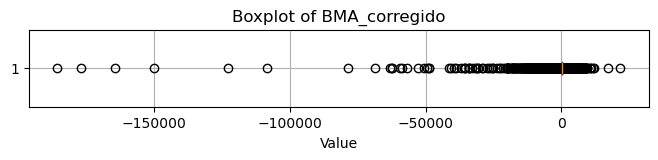

In [27]:
# Boxplot of the KPI
def plot_boxplot(X, var):
    plt.figure(figsize=(8, 1))
    plt.boxplot(X[var], vert=False)
    plt.title('Boxplot of ' + var)
    plt.xlabel('Value')
    plt.grid(True)
    plt.show()

print("Boxplot of KPI in dataset X:\n")
plot_boxplot(df, KPI)

In [28]:
# Compute the average and total benefit before applyting any classification model to filter customers
print(f"Total customers in dataset: {df.shape[0]:,.0f} customers in X")
max_benefit = df[df[KPI] > 0][KPI].sum()
real_benefit = df[KPI].sum()
p_r_benefit = int(round(100 * real_benefit / max_benefit, 0))
avg_r_benefit = df[KPI].mean()
print(f"Based on KPI, maximum possible benefit in X: {max_benefit:,.0f} euros")
print(f"Based on KPI, real benefit before applying any model: {real_benefit:,.0f} euros ({p_r_benefit}% of max)")
# print(f"Based on KPI, avg. benefit before applying any model: {avg_r_benefit:,.2f} euros per cust. in dataset")

Total customers in dataset: 51,618 customers in X
Based on KPI, maximum possible benefit in X: 12,238,483 euros
Based on KPI, real benefit before applying any model: 909,881 euros (7% of max)


## 3. Creating Pareto

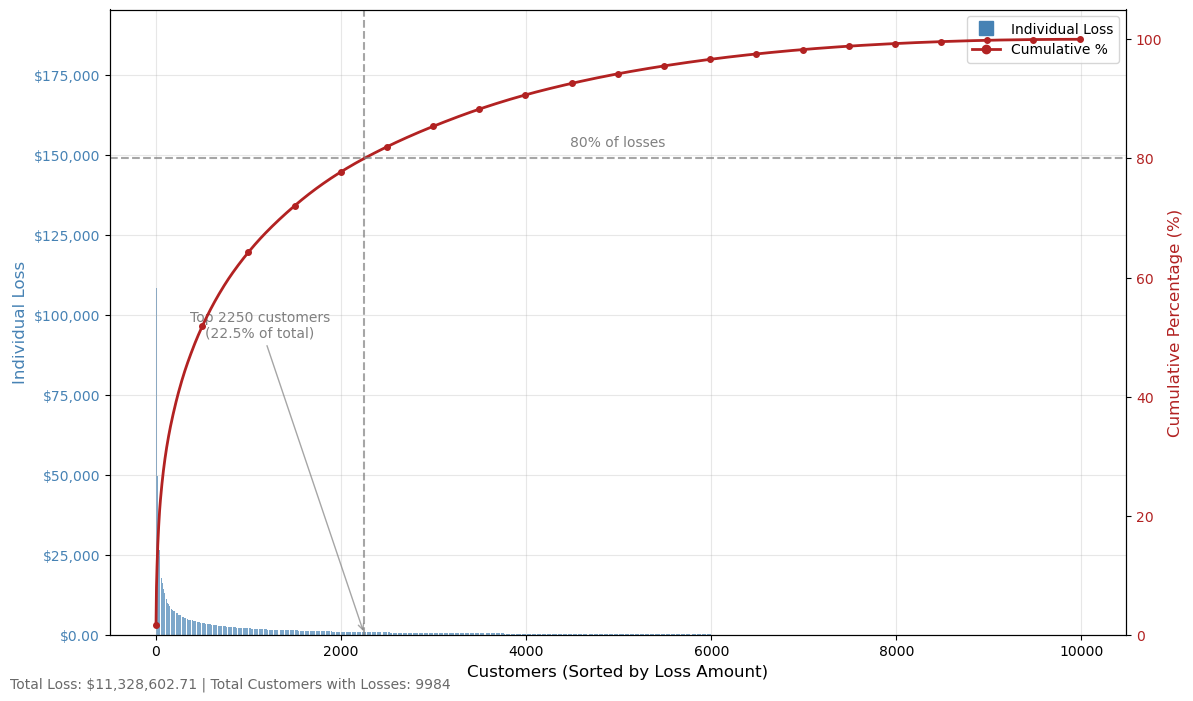

In [29]:
kpi_column = "BMA_corregido"

if kpi_column in df.columns:
    # Filter only loss values (negative values)
    loss_df = df[df[kpi_column] < 0].copy()
    
    # Sort losses from largest to smallest (in absolute terms)
    loss_df = loss_df.sort_values(by=kpi_column, ascending=True)
    
    # Get absolute loss values (convert negative to positive)
    abs_losses = -loss_df[kpi_column].values
    
    # Compute cumulative sum and percentage
    cumulative_losses = np.cumsum(abs_losses)
    total_loss = cumulative_losses[-1]
    cumulative_percentage = (cumulative_losses / total_loss) * 100
    
    # Calculate number of customers
    num_customers = len(abs_losses)
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx()
    
    # Plot individual losses as bars
    bars = ax1.bar(range(num_customers), abs_losses, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Customers (Sorted by Loss Amount)', fontsize=12)
    ax1.set_ylabel('Individual Loss', color='steelblue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    # Format y-axis to use currency or thousand separator
    def currency_formatter(x, pos):
        return f"${x:,.0f}" if x >= 1000 else f"${x:.2f}"
    
    ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    # Plot cumulative percentage as line
    line = ax2.plot(range(num_customers), cumulative_percentage, color='firebrick', 
                   linewidth=2, marker='o', markersize=4, markevery=max(1, num_customers//20))
    ax2.set_ylabel('Cumulative Percentage (%)', color='firebrick', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='firebrick')
    ax2.set_ylim([0, 105])  # Set y-axis limit with some padding
    
    # Add reference lines for 80% cumulative loss
    eighty_percent_idx = np.where(cumulative_percentage >= 80)[0][0]
    eighty_percent_customers = eighty_percent_idx + 1
    
    ax2.axhline(y=80, color='gray', linestyle='--', alpha=0.7)
    ax1.axvline(x=eighty_percent_idx, color='gray', linestyle='--', alpha=0.7)
    
    # Add annotations
    ax2.annotate(f'80% of losses', xy=(num_customers/2, 82), 
                xytext=(num_customers/2, 82), color='gray', ha='center')
    
    ax1.annotate(f'Top {eighty_percent_customers} customers\n({(eighty_percent_customers/num_customers*100):.1f}% of total)',
                xy=(eighty_percent_idx, abs_losses[eighty_percent_idx]/2), 
                xytext=(eighty_percent_idx/2, max(abs_losses)/2),
                color='gray', ha='center', 
                arrowprops=dict(arrowstyle="->", color='gray', alpha=0.7))
    
    # Add grid, title and legend
    ax1.grid(True, alpha=0.3)
    
    # Add total loss info
    fig.text(0.01, 0.01, f'Total Loss: ${total_loss:,.2f} | Total Customers with Losses: {num_customers}', 
             fontsize=10, color='dimgray')
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='steelblue', lw=0, marker='s', markersize=10, label='Individual Loss'),
        Line2D([0], [0], color='firebrick', lw=2, marker='o', markersize=6, label='Cumulative %')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Add table with summary statistics below the plot (optional)
    percentiles = [50, 80, 90, 95, 99]
    percentile_data = []
    
    for p in percentiles:
        idx = np.where(cumulative_percentage >= p)[0][0]
        customers_count = idx + 1
        customers_percentage = (customers_count / num_customers) * 100
        percentile_data.append([p, customers_count, customers_percentage])
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig("pareto.png")
    plt.show()


In [30]:
num_customers_with_losses = (df["BMA_corregido"] < 0).sum()

print(f"Number of customers with losses: {num_customers_with_losses}")

Number of customers with losses: 9984


In [31]:
a=2250/df.shape[0]
a

0.043589445542252706

# 4. Creating test and train split

In [53]:
threshold_value = df["BMA_corregido"].quantile(0.07)

df["High_Loss_Customer"] = df["BMA_corregido"] < threshold_value

In [54]:
y = df["High_Loss_Customer"]

In [55]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [56]:
max_benefit_train = X_train[X_train["BMA_corregido"] > 0][KPI].sum()
real_benefit_train = X_train["BMA_corregido"].sum()
p_real_benefit_train = int(round(100 * real_benefit_train / max_benefit_train, 0))
avg_real_benefit_train = X_train["BMA_corregido"].mean()
print(f"Maximum possible benefit in X_train_val: {max_benefit_train:,.0f} euros")
print(f"Train_val real benefit before models: {real_benefit_train:,.0f} euros ({p_real_benefit_train}% of max)")
print(f"Train_val avg. benefit before models: {avg_real_benefit_train:,.2f} euros per cust. in dataset")

Maximum possible benefit in X_train_val: 6,835,114 euros
Train_val real benefit before models: 267,547 euros (4% of max)
Train_val avg. benefit before models: 9.26 euros per cust. in dataset


In [57]:
X_train.drop(columns=["BMA_corregido", "BMA_pol", "High_Loss_Customer"], inplace=True)
X_val.drop(columns=["BMA_corregido", "BMA_pol", "High_Loss_Customer"], inplace=True)
X_test.drop(columns=["BMA_corregido", "BMA_pol", "High_Loss_Customer"], inplace=True)

In [58]:
# Calculate correlation matrix
corr_matrix = X_train.corr().abs()
#plt.figure(figsize=(10, 8))
#sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
#plt.title('Correlation Matrix')
#plt.show()

# Create a set to store features to drop
to_drop = set()

# Extract upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# For each column in the upper triangle
for column in upper_tri.columns:
    # Get all features that have correlation > 0.8 with current column
    correlated_features = upper_tri.index[upper_tri[column] > 0.8].tolist()
    
    # If there are any highly correlated features
    if correlated_features:
        # Keep the one with higher correlation with target variable
        features_to_examine = [column] + correlated_features
        # Calculate absolute correlation with target for each feature
        corr_with_target = abs(pd.concat([X_train[features_to_examine]], axis=1).corrwith(y_train))
        # Keep the feature with highest correlation to target
        feature_to_keep = corr_with_target.idxmax()
        
        
        # Add all other features to the drop list
        for feature in features_to_examine:
            if feature != feature_to_keep:
                to_drop.add(feature)

# Convert set to list
to_drop = list(to_drop)

# Print removed features
print("The following features have been removed due to high correlation:\n", to_drop)

The following features have been removed due to high correlation:
 ['INE_029', 'INE_006', 'INE_047', 'INE_051', 'INE_011', 'INE_014', 'INE_044', 'INE_022', 'DGC_011', 'INE_049', 'INE_046', 'INE_054', 'REP_004', 'id21', 'INE_013', 'INE_004', 'INE_023', 'INE_017', 'INE_032', 'DGC_004', 'INE_055', 'INE_021', 'id71', 'INE_001', 'id59', 'INE_015', 'INE_053', 'DGC_013', 'INE_003', 'id70', 'INE_026', 'INE_028', 'NumeroDanyosPersonalesSINCO', 'INE_027', 'DGC_006', 'INE_048', 'ComarcaID', 'INE_002', 'TiempoSINCO', 'REP_003', 'INE_041', 'REP_001', 'INE_030', 'FrecuenciaDanyo_MaterialesSINCO', 'INE_035', 'INE_031', 'DGC_001', 'INE_052', 'INE_005', 'INE_036', 'INE_038', 'TotalMatriculasSINCO', 'INE_050', 'DGC_014', 'Edad', 'INE_039']


In [59]:
print("The following features have been removed due to high correlation:\n", len(to_drop))


The following features have been removed due to high correlation:
 56


In [60]:
X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# 5. Training the model

In [61]:
# Configuration parameters
n_estimators = 50  # Number of models in the ensemble
sampling_strategy = 2  # Ratio of majority:minority (1.0 = equal numbers)
random_state = 42  # For reproducibility

In [62]:
print(f"Training set class distribution: {Counter(y_train)}")
print(f"Validation set class distribution: {Counter(y_val)}")

Training set class distribution: Counter({False: 26887, True: 2018})
Validation set class distribution: Counter({False: 6709, True: 518})


In [63]:
class_counts = Counter(y_train)
minority_class = min(class_counts, key=class_counts.get)
majority_class = max(class_counts, key=class_counts.get)

In [64]:
# Get indices for each class
minority_indices = np.where(y_train == minority_class)[0]
majority_indices = np.where(y_train == majority_class)[0]

# Calculate number of majority samples to use based on sampling strategy
n_minority = len(minority_indices)
n_majority_to_sample = int(n_minority * sampling_strategy)

print(f"Number of minority samples: {n_minority}")
print(f"Number of majority samples to use in each model: {n_majority_to_sample}")

Number of minority samples: 2018
Number of majority samples to use in each model: 4036


In [65]:
start = time.time()
estimators = []

# Create and train n_estimators models
for i in range(n_estimators):
    print(f"Training model {i+1}/{n_estimators}...")
    
    # Create a base estimator (RandomForest in this case)
    estimator = RandomForestClassifier(random_state=random_state+i, n_jobs=-1)
    
    # Sample from majority class
    np.random.seed(random_state + i)
    majority_sample_indices = np.random.choice(
        majority_indices, 
        size=min(n_majority_to_sample, len(majority_indices)), 
        replace=False
    )
    
    # Combine with all minority samples
    sample_indices = np.concatenate([minority_indices, majority_sample_indices])
    
    # Extract the balanced training subset
    X_sampled = X_train.iloc[sample_indices]
    y_sampled = y_train.iloc[sample_indices]
    
    # Train the model on the balanced subset
    estimator.fit(X_sampled, y_sampled)
    
    # Add to our list of estimators
    estimators.append(estimator)

# Make predictions with each model
all_predictions = np.array([estimator.predict(X_val) for estimator in estimators])

# Combine predictions through majority voting
final_predictions = np.apply_along_axis(
    lambda x: np.argmax(np.bincount(x, minlength=len(np.unique(y_val)))),
    axis=0,
    arr=all_predictions
)
end = time.time()
print(f"Finished in {end-start} seconds") 



Training model 1/50...
Training model 2/50...
Training model 3/50...
Training model 4/50...
Training model 5/50...
Training model 6/50...
Training model 7/50...
Training model 8/50...
Training model 9/50...
Training model 10/50...
Training model 11/50...
Training model 12/50...
Training model 13/50...
Training model 14/50...
Training model 15/50...
Training model 16/50...
Training model 17/50...
Training model 18/50...
Training model 19/50...
Training model 20/50...
Training model 21/50...
Training model 22/50...
Training model 23/50...
Training model 24/50...
Training model 25/50...
Training model 26/50...
Training model 27/50...
Training model 28/50...
Training model 29/50...
Training model 30/50...
Training model 31/50...
Training model 32/50...
Training model 33/50...
Training model 34/50...
Training model 35/50...
Training model 36/50...
Training model 37/50...
Training model 38/50...
Training model 39/50...
Training model 40/50...
Training model 41/50...
Training model 42/50...
T


Confusion Matrix:
[[6290  419]
 [ 397  121]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.94      0.94      6709
        True       0.22      0.23      0.23       518

    accuracy                           0.89      7227
   macro avg       0.58      0.59      0.58      7227
weighted avg       0.89      0.89      0.89      7227



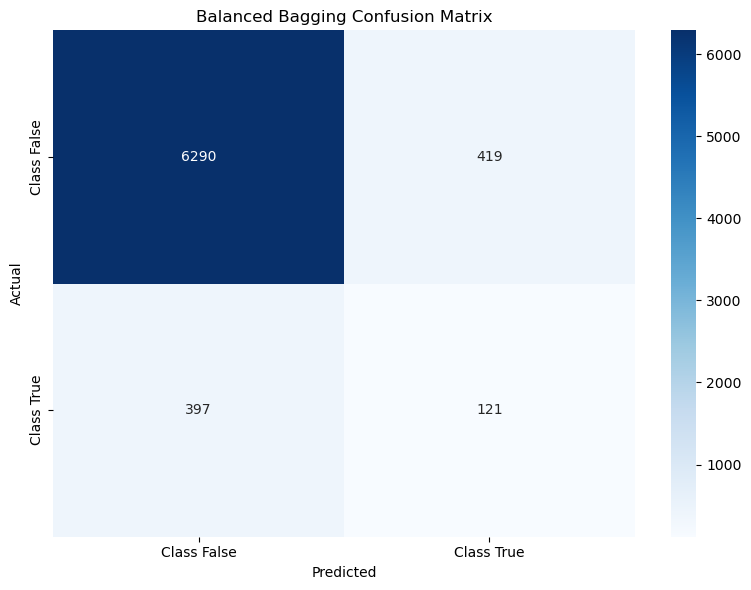

In [66]:
# Calculate performance metrics
conf_matrix = confusion_matrix(y_val, final_predictions)
class_report = classification_report(y_val, final_predictions)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in np.unique(y)],
            yticklabels=[f'Class {i}' for i in np.unique(y)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Balanced Bagging Confusion Matrix')
plt.tight_layout()
plt.savefig("appraoch3.png")
plt.show()


In [67]:
profit(X_val, final_predictions, df_original, "Validation set", "after")

Maximum possible benefit in Validation set: 1,728,523 euros
Validation set real benefit after models: 491,516 euros (28% of max)
Validation set avg. benefit after models: 73.50 euros per cust. in dataset
Clients excluded: 7.47%


# 6. Final Result

In [71]:
start = time.time()
test_predictions = np.array([estimator.predict(X_test) for estimator in estimators])

# Combine predictions through majority voting (same method as before)
final_test_predictions = np.apply_along_axis(
    lambda x: np.argmax(np.bincount(x, minlength=len(np.unique(y_test)))),
    axis=0,
    arr=test_predictions
)
end = time.time()
print(f"Finished in {end-start} seconds") 


Finished in 7.288081645965576 seconds



Confusion Matrix:
[[13415   993]
 [  813   265]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.93      0.94     14408
        True       0.21      0.25      0.23      1078

    accuracy                           0.88     15486
   macro avg       0.58      0.59      0.58     15486
weighted avg       0.89      0.88      0.89     15486



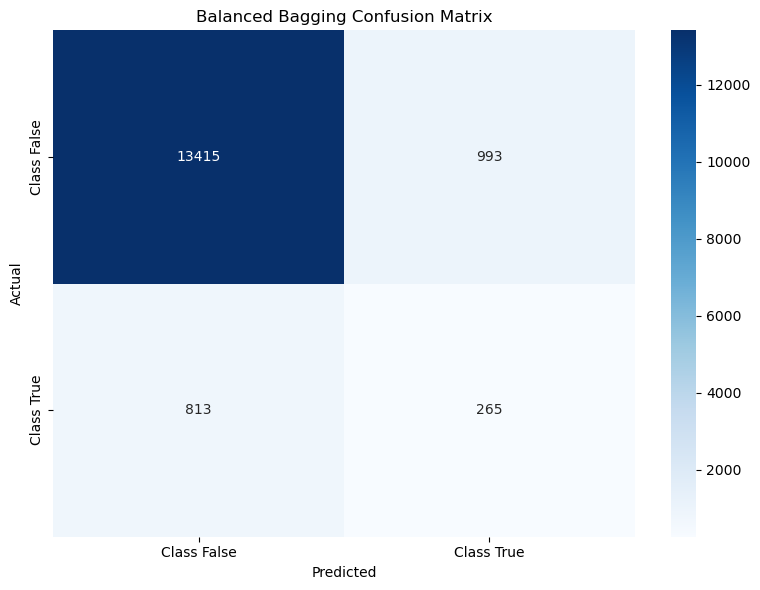

In [72]:
# Calculate performance metrics
conf_matrix = confusion_matrix(y_test, final_test_predictions)
class_report = classification_report(y_test, final_test_predictions)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in np.unique(y)],
            yticklabels=[f'Class {i}' for i in np.unique(y)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Balanced Bagging Confusion Matrix')
plt.tight_layout()
plt.savefig("final.png")
plt.show()


In [73]:
profit(X_test, final_test_predictions, df_original, "Test dataset", "after")

Maximum possible benefit in Test dataset: 3,674,846 euros
Test dataset real benefit after models: 1,275,284 euros (35% of max)
Test dataset avg. benefit after models: 89.63 euros per cust. in dataset
Clients excluded: 8.12%


# Help functions

In [48]:
# Drop the ones classified as 1 in the prediction of the model (y_pred)
def profit(X_test, y_pred, df_original, set, timing):

    X = X_test.copy()
    X['pred'] = y_pred
    
    benefit = df_original["BMA_corregido"]
    result = pd.merge(X, benefit, left_index=True, right_index=True, how="inner")

    max_benefit = result[result["BMA_corregido"] > 0][KPI].sum()
    real_benefit = result[result.pred == 0]["BMA_corregido"].sum()
    p_real_benefit = int(round(100 * real_benefit / max_benefit, 0))
    avg_real_benefit = result[result.pred == 0]["BMA_corregido"].mean()
    clients_excluded = len(X[y_pred == 1]) / len(X) * 100
    print(f"Maximum possible benefit in {set}: {max_benefit:,.0f} euros")
    print(f"{set} real benefit {timing} models: {real_benefit:,.0f} euros ({p_real_benefit}% of max)")
    print(f"{set} avg. benefit {timing} models: {avg_real_benefit:,.2f} euros per cust. in dataset")
    print(f"Clients excluded: {clients_excluded:,.2f}%")
